# Taxi Demand Prediction - Support Vector Machine
---
In this notebook, we build a model for predicting taxi demand in Chicago. The model is based on the information provided by the city of Chicago in 2015.

Furthermore, the model is based on all of the available data. Since the prediction target is taxi demand which is calculated by data aggregation, we won't encounter any memory problems.

To build our demand prediction model, we proceed as following:

- Data preparation
    - Feature engineering (spatial and temporal features)
    - Preprocessing
- Model building (with different spatial attributes)
- Finding svm architecture in an iterative process
- Tuning the hyperparameters of the final architecture for each model (daily, 6H, and hourly)
- Model evaluations
- Result Analysis
- Conclusion and outlook

In [1]:
cd ..

/Users/simonwolf/git/aaa21


In [2]:
import utils, feature_engineering, geo_engineering, preprocessing, prediction_utils, prediction_svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
%matplotlib inline
pd.options.mode.chained_assignment = None

# Daily Models
---
To help taxi companies prepare for daily demand in different part of the city we build a daily demand predictin model using support vector machine. This model will help the cab industry to better utilize its resources and is also beneficial for mid-long term planning. The model is based on the 2015 information.

**Model input:**
- Geographical area where the customer is expected
- Date
- Weather Information

**Model output:**
- Demand for the given date at the given area

## Data Preparation
---

In [41]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet',
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

daily_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D')
daily_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
                                            use_hexes=True,hex_resolution=7)
daily_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [42]:
#Spatial Features
daily_demand = feature_engineering.add_spatial_features(daily_demand)
daily_demand_hex_7 = feature_engineering.add_spatial_features(daily_demand_hex_7,with_hex=7,hex_res=7)
daily_demand_hex_6 = feature_engineering.add_spatial_features(daily_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
daily_demand = feature_engineering.add_holidays(daily_demand)
daily_demand_hex_6 = feature_engineering.add_holidays(daily_demand_hex_6)
daily_demand_hex_7 = feature_engineering.add_holidays(daily_demand_hex_7)

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the svm architecture we first start our daily model by a simple linear kernel. After observing the behavoiur of the model we adjust the model. First by changing kernels, second by increasing/decreasing our hyperparameters. For the sake of brevity this notebook does not show all tested svm architectures.

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

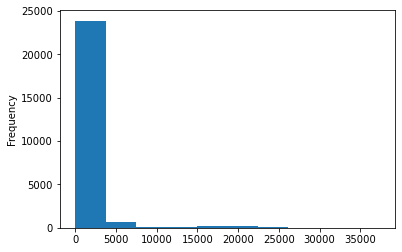

In [5]:
daily_demand['Demand (D)'].plot.hist()
plt.show()

As we expected the target is extremely skewed. Which would make the prediction metrics non telling. To tackle this obstacle, we transform the target logarithmically. And use the mean squared logarithmic error as our metric.

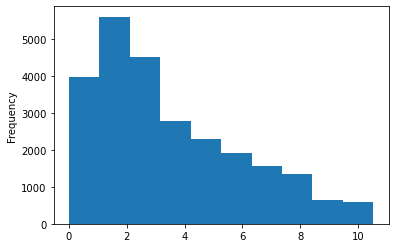

In [6]:
daily_demand['Demand (D)'] = np.log(daily_demand['Demand (D)'])
daily_demand['Demand (D)'].plot.hist()
plt.show()

### Preprocessing
---

In [7]:
daily_demand, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(daily_demand, 
                                                                            temporal_resolution='D'))

In [8]:
#Preprocessed data
daily_demand.head(5)

,Pickup Community Area,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,6.006353,100.0,1034.250777,-5.435774,249.09522,9.069681,14.731612,19.688474,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,10,3.465736,100.0,1034.250777,-5.435774,249.09522,9.069681,18.830572,8.403423,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,11,4.290459,100.0,1034.250777,-5.435774,249.09522,9.069681,16.315833,11.040063,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,12,2.708050,100.0,1034.250777,-5.435774,249.09522,9.069681,16.744923,12.216892,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,13,3.663562,100.0,1034.250777,-5.435774,249.09522,9.069681,14.040299,14.983269,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [9]:
#Train - Test Split
daily_demand_train, daily_demand_test = prediction_svm.split_data_sets_for_svm(daily_demand, test_size=0.2)

In [10]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


## Model Building
## Daily Model - Community Areas
---

In this section we build our svm model for demand prediction using community areas as our geographical attributes. we build different models and opt for the final model by comparing the overall evaluation metrics. Later on, we will use this model for prediction using differenct geographical attributes.

---


In [11]:
# Target Extraction
daily_demand_train_target = daily_demand_train.pop(target)
daily_demand_test_target = daily_demand_test[target]
X_test = daily_demand_test.drop(columns=[target])

### SVM Model With Linear Kernel

- without regularization
- using default values for hyperparameters
---

In [12]:
svr_linear = SVR(kernel='linear')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_linear)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [13]:
# Training SVM Linear Kernel
svr_linear_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

#### Linear Model Evaluation
---
To get the result for our baseline linear model we use the test set for evaluation

In [14]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  45.839 %
sMAPE:  34.270 %
MAE:  208.832
MSE:  819604.170
RMSE:  905.320
R2:  90.511 %
Max Residual Error:  16207.762


The above shows the result of our first model. We see that a linear model is already quite a good fit, by catching 90% of the variability of the dependent variable. Still, other metrics demonstrate some downsights e.g. the mean average error exhibits a value of over 200 trips. 

### SVM Model With Polynomial Kernel

Analogously, we create a further baseline model by just changing the kernel to a polynomial one. This contributes to later on being able to select the best performing kernel. 

As degree one has already been build above, we proceed with degree two. Afterwards, we try higher degrees as long as our metrics are improving.

---

#### Degree 2
---

In [15]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [16]:
# Training SVM Polynomial Degree 2 Kernel
svr_poly_2_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

#### Polynomial Model Evaluation (degree 2)
---
To get the result for our baseline polynomial model with degree 2 we use the test set for evaluation

In [17]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  45.873 %
sMAPE:  33.242 %
MAE:  187.268
MSE:  677499.353
RMSE:  823.103
R2:  92.156 %
Max Residual Error:  12829.874


The above shows the result of our first model. We obwerve a significant improvement in cotrast to the linear model, as now the mean absolute error decresed to less than 200, namely 180, while also improving catching the variance with 92%.

#### Degree 3
---

In [18]:
svr_poly_3 = SVR(kernel='poly', degree=3)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_3)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [19]:
# Training SVM Polynomial Degree 3 Kernel
svr_poly_3_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [20]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  51.566 %
sMAPE:  35.960 %
MAE:  209.153
MSE:  866579.410
RMSE:  930.902
R2:  89.967 %
Max Residual Error:  16351.016


### SVM Model With RBF Kernel
---

In [21]:
svr_rbf = SVR(kernel='rbf')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [22]:
# Training SVM RBF Kernel
svr_rbf_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [23]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  65.211 %
sMAPE:  42.001 %
MAE:  272.302
MSE:  1695807.462
RMSE:  1302.232
R2:  80.366 %
Max Residual Error:  18734.702


Overfit to training data -> tune hyperparameter!

## Hyperparameter Tunig for Final Model
---

We perform a grid search with five time series splits on the training set using our final model.

Doing so, we tune the following hyper parameters to avoid overfitting:
- Regularization
- Independent term in kernel function
- Epsilon (Kernel coefficient)
- Gamma (area within which no penalty is associated in the training loss function with predictions within the distance epsilon from the actual value)

In [24]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [25]:
# Define Model Parameters for Grid Search [0.5, 4, 32, 256]
model_params = {
                'svr model__C':[2**j for j in range(-1,10,3)],        
                'svr model__epsilon':[2**j for j in range(-1,10,3)],  
                'svr model__coef0':[2**j for j in range(-1,10,3)],    
                'svr model__gamma':[2**j for j in range(-1,10,3)]    
                }

In [26]:
# Grid Search
prediction_svm.find_best_parameters_for_model(pipeline, 
                                              daily_demand_train, 
                                              daily_demand_train_target, 
                                              model_params, 
                                              scoring='neg_mean_absolute_error',
                                              n_iter=100,
                                              verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best neg_mean_absolute_error Score was: -0.37834259640609386
The best hyper parameters for the model are:
{'svr model__gamma': 0.5, 'svr model__epsilon': 0.5, 'svr model__coef0': 256, 'svr model__C': 32}


In [27]:
# Train Model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [28]:
svr_tuned_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [29]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


### Adding Demand to visualize Prediction in the end
---

In [30]:
daily_demand_test['Demand (D)'] = np.exp(daily_demand_test['Demand (D)']).astype(int)
daily_demand_test['Demand (D) Prediction'] = np.exp(y_pred).astype(int)
daily_demand_test

,Pickup Community Area,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Demand (D) Prediction
20196,66,2,36.060457,1022.337191,13.970258,198.297404,7.391849,13.624895,28.778173,False,...,0,292,False,False,False,False,False,False,1445212800,2
20197,67,4,36.060457,1022.337191,13.970258,198.297404,7.391849,12.313010,29.943480,False,...,0,292,False,False,False,False,False,False,1445212800,2
20198,68,4,36.060457,1022.337191,13.970258,198.297404,7.391849,11.744408,31.191740,False,...,0,292,False,False,False,False,False,False,1445212800,5
20199,69,10,36.060457,1022.337191,13.970258,198.297404,7.391849,13.198950,33.830087,False,...,0,292,False,False,False,False,False,False,1445212800,4
20200,7,1699,36.060457,1022.337191,13.970258,198.297404,7.391849,5.037754,22.004336,False,...,0,292,False,False,False,False,False,False,1445212800,2552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25240,73,1,75.061278,1024.788420,-2.917027,265.509481,5.001468,18.397504,35.945244,False,...,3,365,True,False,True,False,True,False,1451520000,3
25241,75,1,75.061278,1024.788420,-2.917027,265.509481,5.001468,21.696836,37.590629,False,...,3,365,True,False,True,False,True,False,1451520000,1
25242,76,1450,75.061278,1024.788420,-2.917027,265.509481,5.001468,24.693040,0.967604,False,...,3,365,True,False,True,False,True,False,1451520000,3722
25243,77,736,75.061278,1024.788420,-2.917027,265.509481,5.001468,12.127869,19.965937,False,...,3,365,True,False,True,False,True,False,1451520000,606


## Daily Model - Hex 7
---

In this section we build our svm model for demand prediction using hex 7 as our geographical attributes. We build different models and opt for the final model by comparing the overall evaluation metrics.

---

In [43]:
#Log transformation
daily_demand_hex_7['Demand (D)'] = np.log(daily_demand_hex_7['Demand (D)'])

In [44]:
daily_demand_hex_7, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(daily_demand_hex_7, 
                                                                            temporal_resolution='D'))

In [45]:
#Train - Test Split
daily_demand_hex_7_train, daily_demand_hex_7_test = prediction_svm.split_data_sets_for_svm(daily_demand_hex_7, test_size=0.2)

In [46]:
#Augmented data
daily_demand_hex_7_train.head(5)

,hex_7_pickup,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,608661331456819199,0.000000,100.0,1034.250777,-5.435774,249.09522,9.069681,25.700209,46.914475,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,608661331540705279,0.693147,100.0,1034.250777,-5.435774,249.09522,9.069681,21.400592,41.959487,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,608661346740862975,6.493754,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,608661346757640191,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,15.882880,25.185694,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,608661346942189567,0.000000,100.0,1034.250777,-5.435774,249.09522,9.069681,16.123857,27.587471,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [47]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week', 'hex_7_pickup']


In [48]:
# Target Extraction
daily_demand_hex_7_train_target = daily_demand_hex_7_train.pop(target)
daily_demand_hex_7_test_target = daily_demand_hex_7_test[target]
X_test = daily_demand_hex_7_test.drop(columns=[target])

In [49]:
# Train same model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [50]:
svr_tuned_fitted = pipeline.fit(daily_demand_hex_7_train, daily_demand_hex_7_train_target)

In [51]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_hex_7_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  44.400 %
sMAPE:  35.012 %
MAE:  178.721
MSE:  515523.767
RMSE:  718.000
R2:  93.938 %
Max Residual Error:  13031.193


## Daily Model - Hex 6
---

In this section we build our svm model for demand prediction using hex 6 as our geographical attributes. We build different models and opt for the final model by comparing the overall evaluation metrics.

---

In [52]:
#Log transformation
daily_demand_hex_6['Demand (D)'] = np.log(daily_demand_hex_6['Demand (D)'])

In [53]:
daily_demand_hex_6, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(daily_demand_hex_6, 
                                                                            temporal_resolution='D'))

In [54]:
#Train - Test Split
daily_demand_hex_6_train, daily_demand_hex_6_test = prediction_svm.split_data_sets_for_svm(daily_demand_hex_6, test_size=0.2)

In [55]:
#Augmented data
daily_demand_hex_6_train.head(5)

,hex_6_pickup,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,604157731930111999,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,23.517915,44.436933,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,604157731930111999,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,23.517915,44.436933,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,604157747230932991,6.498282,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,604157747230932991,6.498282,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,604157747365150719,1.386294,100.0,1034.250777,-5.435774,249.09522,9.069681,18.393286,29.242876,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [56]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['hex_6_pickup', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


In [57]:
# Target Extraction
daily_demand_hex_6_train_target = daily_demand_hex_6_train.pop(target)
daily_demand_hex_6_test_target = daily_demand_hex_6_test[target]
X_test = daily_demand_hex_6_test.drop(columns=[target])

In [58]:
# Train same model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [59]:
svr_tuned_fitted = pipeline.fit(daily_demand_hex_6_train, daily_demand_hex_6_train_target)

In [60]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_hex_6_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  45.451 %
sMAPE:  32.101 %
MAE:  551.743
MSE:  4162838.324
RMSE:  2040.303
R2:  91.157 %
Max Residual Error:  31007.687


In [61]:
#Memory Cleaning
del daily_demand
del daily_demand_hex_6
del daily_demand_hex_7

# 6h Models
---

## Data Preparation
---

In [62]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet',
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

six_hour_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H')
six_hour_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H',
                                            use_hexes=True,hex_resolution=7)
six_hour_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [63]:
#Spatial Features
six_hour_demand = feature_engineering.add_spatial_features(six_hour_demand)
six_hour_demand_hex_7 = feature_engineering.add_spatial_features(six_hour_demand_hex_7,with_hex=7,hex_res=7)
six_hour_demand_hex_6 = feature_engineering.add_spatial_features(six_hour_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
six_hour_demand = feature_engineering.add_holidays(six_hour_demand)
six_hour_demand_hex_6 = feature_engineering.add_holidays(six_hour_demand_hex_6)
six_hour_demand_hex_7 = feature_engineering.add_holidays(six_hour_demand_hex_7)

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the svm architecture we first start our daily model by a simple linear kernel. After observing the behavoiur of the model we adjust the model. First by changing kernels, second by increasing/decreasing our hyperparameters. For the sake of brevity this notebook does not show all tested svm architectures.

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

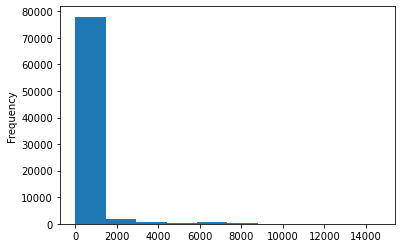

In [64]:
six_hour_demand['Demand (6H)'].plot.hist()
plt.show()

As we expected the target is extremely skewed. Which would make the prediction metrics non telling. To tackle this obstacle, we transform the target logarithmically. And use the mean squared logarithmic error as our metric.

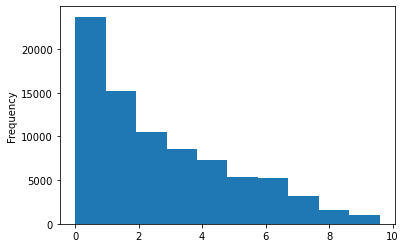

In [65]:
six_hour_demand['Demand (6H)'] = np.log(six_hour_demand['Demand (6H)'])
six_hour_demand['Demand (6H)'].plot.hist()
plt.show()

### Preprocessing
---

In [66]:
six_hour_demand, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(six_hour_demand, 
                                                                            temporal_resolution='6H'))

In [67]:
#Preprocessed data
six_hour_demand.head(5)

,Pickup Community Area,Demand (6H),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,1,5.529429,100.0,1037.346969,-6.504509,247.772577,9.826516,14.731612,19.688474,False,...,2,365,True,False,True,False,True,False,23,1420066800
1,10,2.197225,100.0,1037.346969,-6.504509,247.772577,9.826516,18.830572,8.403423,False,...,2,365,True,False,True,False,True,False,23,1420066800
2,11,3.555348,100.0,1037.346969,-6.504509,247.772577,9.826516,16.315833,11.040063,False,...,2,365,True,False,True,False,True,False,23,1420066800
3,12,1.098612,100.0,1037.346969,-6.504509,247.772577,9.826516,16.744923,12.216892,False,...,2,365,True,False,True,False,True,False,23,1420066800
4,13,2.639057,100.0,1037.346969,-6.504509,247.772577,9.826516,14.040299,14.983269,False,...,2,365,True,False,True,False,True,False,23,1420066800


In [68]:
#Train - Test Split
six_hour_demand_train, six_hour_demand_test = prediction_svm.split_data_sets_for_svm(six_hour_demand, test_size=0.2)

In [69]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week']


## Model Building
## 6h - Community Areas
---

In this section we build our svm model for demand prediction using community areas as our geographical attributes. we build different models and opt for the final model by comparing the overall evaluation metrics. Later on, we will use this model for prediction using differenct geographical attributes.

---


In [70]:
# Target Extraction
six_hour_demand_train_target = six_hour_demand_train.pop(target)
six_hour_demand_test_target = six_hour_demand_test[target]
X_test = six_hour_demand_test.drop(columns=[target])

### SVM Model With Linear Kernel

- without regularization
- using default values for hyperparameters
---

In [71]:
svr_linear = SVR(kernel='linear')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_linear)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [72]:
# Training SVM Linear Kernel
svr_linear_fitted = pipeline.fit(six_hour_demand_train, six_hour_demand_train_target)

#### Linear Model Evaluation
---
To get the result for our baseline linear model we use the test set for evaluation

In [73]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  55.179 %
sMAPE:  44.379 %
MAE:  107.797
MSE:  221465.679
RMSE:  470.601
R2:  73.752 %
Max Residual Error:  6302.095


The above shows the result of our first model. We see that a linear model is already quite a good fit, by catching 90% of the variability of the dependent variable. Still, other metrics demonstrate some downsights e.g. the mean average error exhibits a value of over 200 trips. 

### SVM Model With Polynomial Kernel

Analogously, we create a further baseline model by just changing the kernel to a polynomial one. This contributes to later on being able to select the best performing kernel. 

As degree one has already been build above, we proceed with degree two. Afterwards, we try higher degrees as long as our metrics are improving.

---

#### Degree 2
---

In [74]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [75]:
# Training SVM Polynomial Degree 2 Kernel
svr_poly_2_fitted = pipeline.fit(six_hour_demand_train, six_hour_demand_train_target)

#### Polynomial Model Evaluation (degree 2)
---
To get the result for our baseline polynomial model with degree 2 we use the test set for evaluation

In [76]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  51.647 %
sMAPE:  37.305 %
MAE:  65.844
MSE:  85149.208
RMSE:  291.803
R2:  89.908 %
Max Residual Error:  5705.277


The above shows the result of our first model. We obwerve a significant improvement in cotrast to the linear model, as now the mean absolute error decresed to less than 200, namely 180, while also improving catching the variance with 92%.

#### Degree 3
---

In [77]:
svr_poly_3 = SVR(kernel='poly', degree=3)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_3)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [78]:
# Training SVM Polynomial Degree 3 Kernel
svr_poly_3_fitted = pipeline.fit(six_hour_demand_train, six_hour_demand_train_target)

In [79]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  53.230 %
sMAPE:  37.779 %
MAE:  63.345
MSE:  79479.762
RMSE:  281.922
R2:  90.580 %
Max Residual Error:  5872.099


### SVM Model With RBF Kernel
---

In [80]:
svr_rbf = SVR(kernel='rbf')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [81]:
# Training SVM RBF Kernel
svr_rbf_fitted = pipeline.fit(six_hour_demand_train, six_hour_demand_train_target)

In [82]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  68.438 %
sMAPE:  43.981 %
MAE:  83.798
MSE:  158496.028
RMSE:  398.116
R2:  81.215 %
Max Residual Error:  6994.572


Overfit to training data -> tune hyperparameter!

## Hyperparameter Tunig for Final Model
---

We perform a grid search with five time series splits on the training set using our final model.

Doing so, we tune the following hyper parameters to avoid overfitting:
- Regularization
- Independent term in kernel function
- Epsilon (Kernel coefficient)
- Gamma (area within which no penalty is associated in the training loss function with predictions within the distance epsilon from the actual value)

In [83]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [90]:
# Define Model Parameters for Grid Search [0.5, 4, 32, 256]
model_params = {
                'svr model__C':[2**j for j in range(-1,10,3)],        
                'svr model__epsilon':[2**j for j in range(-1,10,3)],  
                'svr model__coef0':[2**j for j in range(-1,10,3)],    
                'svr model__gamma':[2**j for j in range(-1,10,3)]    
                }

In [91]:
# Grid Search
prediction_svm.find_best_parameters_for_model(pipeline, 
                                              six_hour_demand_train, 
                                              six_hour_demand_train_target, 
                                              model_params, 
                                              scoring='neg_mean_absolute_error',
                                              n_iter=100,
                                              verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [60]:
# Train Model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [61]:
svr_tuned_fitted = pipeline.fit(six_hour_demand_train, six_hour_demand_train_target)

In [62]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


### Adding Demand to visualize Prediction in the end
---

In [ ]:
six_hour_demand_test['Demand (6H)'] = np.exp(six_hour_demand_test['Demand (6H)']).astype(int)
six_hour_demand_test['Demand (6H) Prediction'] = np.exp(y_pred).astype(int)
six_hour_demand_test

## 6h Model - Hex 7
---

In this section we build our svm model for demand prediction using hex 7 as our geographical attributes. We build different models and opt for the final model by comparing the overall evaluation metrics.

---

In [65]:
#Log transformation
six_hour_demand_hex_7['Demand (6H)'] = np.log(six_hour_demand_hex_7['Demand (6H)'])

In [66]:
six_hour_demand_hex_7, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(six_hour_demand_hex_7, 
                                                                            temporal_resolution='6H'))

In [67]:
#Train - Test Split
six_hour_demand_hex_7_train, six_hour_demand_hex_7_test = prediction_svm.split_data_sets_for_svm(six_hour_demand_hex_7, test_size=0.2)

In [68]:
#Augmented data
six_hour_demand_hex_7_train.head(5)

,hex_7_pickup,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,608661331456819199,0.000000,100.0,1034.250777,-5.435774,249.09522,9.069681,25.700209,46.914475,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,608661331540705279,0.693147,100.0,1034.250777,-5.435774,249.09522,9.069681,21.400592,41.959487,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,608661346740862975,6.493754,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,608661346757640191,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,15.882880,25.185694,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,608661346942189567,0.000000,100.0,1034.250777,-5.435774,249.09522,9.069681,16.123857,27.587471,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [69]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week', 'hex_7_pickup']


In [70]:
# Target Extraction
six_hour_demand_hex_7_train_target = six_hour_demand_hex_7_train.pop(target)
six_hour_demand_hex_7_test_target = six_hour_demand_hex_7_test[target]
X_test = six_hour_demand_hex_7_test.drop(columns=[target])

In [71]:
# Train same model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [61]:
svr_tuned_fitted = pipeline.fit(six_hour_demand_hex_7_train, six_hour_demand_hex_7_train_target)

In [62]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_hex_7_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


## 6h Model - Hex 6
---

In this section we build our svm model for demand prediction using hex 6 as our geographical attributes. We build different models and opt for the final model by comparing the overall evaluation metrics.

---

In [72]:
#Log transformation
six_hour_demand_hex_6['Demand (6H)'] = np.log(six_hour_demand_hex_6['Demand (6H)'])

In [73]:
six_hour_demand_hex_6, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(six_hour_demand_hex_6, 
                                                                            temporal_resolution='6H'))

In [74]:
#Train - Test Split
six_hour_demand_hex_6_train, six_hour_demand_hex_6_test = prediction_svm.split_data_sets_for_svm(six_hour_demand_hex_6, test_size=0.2)

In [75]:
#Augmented data
six_hour_demand_hex_6_train.head(5)

,hex_6_pickup,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,604157731930111999,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,23.517915,44.436933,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,604157731930111999,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,23.517915,44.436933,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,604157747230932991,6.498282,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,604157747230932991,6.498282,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,604157747365150719,1.386294,100.0,1034.250777,-5.435774,249.09522,9.069681,18.393286,29.242876,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [76]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['hex_6_pickup', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


In [77]:
# Target Extraction
six_hour_demand_hex_6_train_target = six_hour_demand_hex_6_train.pop(target)
six_hour_demand_hex_6_test_target = six_hour_demand_hex_6_test[target]
X_test = six_hour_demand_hex_6_test.drop(columns=[target])

In [78]:
# Train same model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [61]:
svr_tuned_fitted = pipeline.fit(six_hour_demand_hex_6_train, six_hour_demand_hex_6_train_target)

In [62]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(six_hour_demand_hex_6_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


In [21]:
#Memory Cleaning
del six_hour_demand
del six_hour_demand_hex_6
del six_hour_demand_hex_7

# Hourly Models
---

## Data Preparation
---

In [80]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet',
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

hourly_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H')
hourly_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H',
                                            use_hexes=True,hex_resolution=7)
hourly_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [81]:
#Spatial Features
hourly_demand = feature_engineering.add_spatial_features(hourly_demand)
hourly_demand_hex_7 = feature_engineering.add_spatial_features(hourly_demand_hex_7,with_hex=7,hex_res=7)
hourly_demand_hex_6 = feature_engineering.add_spatial_features(hourly_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
hourly_demand = feature_engineering.add_holidays(hourly_demand)
hourly_demand_hex_6 = feature_engineering.add_holidays(hourly_demand_hex_6)
hourly_demand_hex_7 = feature_engineering.add_holidays(hourly_demand_hex_7)

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the svm architecture we first start our daily model by a simple linear kernel. After observing the behavoiur of the model we adjust the model. First by changing kernels, second by increasing/decreasing our hyperparameters. For the sake of brevity this notebook does not show all tested svm architectures.

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

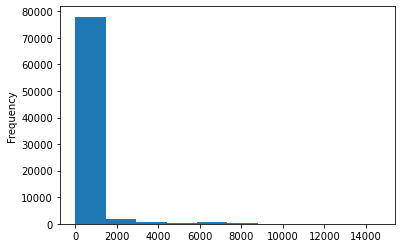

In [82]:
hourly_demand['Demand (H)'].plot.hist()
plt.show()

As we expected the target is extremely skewed. Which would make the prediction metrics non telling. To tackle this obstacle, we transform the target logarithmically. And use the mean squared logarithmic error as our metric.

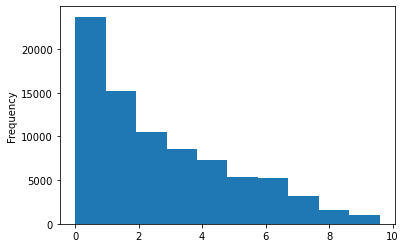

In [83]:
hourly_demand['Demand (H)'] = np.log(hourly_demand['Demand (H)'])
hourly_demand['Demand (H)'].plot.hist()
plt.show()

### Preprocessing
---

In [84]:
hourly_demand, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(hourly_demand, 
                                                                            temporal_resolution='H'))

In [85]:
#Preprocessed data
hourly_demand.head(5)

,Pickup Community Area,Demand (6H),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,1,5.529429,100.0,1037.346969,-6.504509,247.772577,9.826516,14.731612,19.688474,False,...,2,365,True,False,True,False,True,False,23,1420066800
1,10,2.197225,100.0,1037.346969,-6.504509,247.772577,9.826516,18.830572,8.403423,False,...,2,365,True,False,True,False,True,False,23,1420066800
2,11,3.555348,100.0,1037.346969,-6.504509,247.772577,9.826516,16.315833,11.040063,False,...,2,365,True,False,True,False,True,False,23,1420066800
3,12,1.098612,100.0,1037.346969,-6.504509,247.772577,9.826516,16.744923,12.216892,False,...,2,365,True,False,True,False,True,False,23,1420066800
4,13,2.639057,100.0,1037.346969,-6.504509,247.772577,9.826516,14.040299,14.983269,False,...,2,365,True,False,True,False,True,False,23,1420066800


In [87]:
#Train - Test Split
hourly_demand_train, hourly_demand_test = prediction_svm.split_data_sets_for_svm(hourly_demand, test_size=0.2)

In [88]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week']


## Model Building
## Hourly - Community Areas
---

In this section we build our svm model for demand prediction using community areas as our geographical attributes. we build different models and opt for the final model by comparing the overall evaluation metrics. Later on, we will use this model for prediction using differenct geographical attributes.

---


In [89]:
# Target Extraction
hourly_demand_train_target = hourly_demand_train.pop(target)
hourly_demand_test_target = hourly_demand_test[target]
X_test = hourly_demand_test.drop(columns=[target])

### SVM Model With Linear Kernel

- without regularization
- using default values for hyperparameters
---

In [90]:
svr_linear = SVR(kernel='linear')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_linear)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [ ]:
# Training SVM Linear Kernel
svr_linear_fitted = pipeline.fit(hourly_demand_train, hourly_demand_train_target)

#### Linear Model Evaluation
---
To get the result for our baseline linear model we use the test set for evaluation

In [ ]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

The above shows the result of our first model. We see that a linear model is already quite a good fit, by catching 90% of the variability of the dependent variable. Still, other metrics demonstrate some downsights e.g. the mean average error exhibits a value of over 200 trips. 

### SVM Model With Polynomial Kernel

Analogously, we create a further baseline model by just changing the kernel to a polynomial one. This contributes to later on being able to select the best performing kernel. 

As degree one has already been build above, we proceed with degree two. Afterwards, we try higher degrees as long as our metrics are improving.

---

#### Degree 2
---

In [ ]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

In [ ]:
# Training SVM Polynomial Degree 2 Kernel
svr_poly_2_fitted = pipeline.fit(hourly_demand_train, hourly_demand_train_target)

#### Polynomial Model Evaluation (degree 2)
---
To get the result for our baseline polynomial model with degree 2 we use the test set for evaluation

In [ ]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

The above shows the result of our first model. We obwerve a significant improvement in cotrast to the linear model, as now the mean absolute error decresed to less than 200, namely 180, while also improving catching the variance with 92%.

#### Degree 3
---

In [ ]:
svr_poly_3 = SVR(kernel='poly', degree=3)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_3)

pipeline

In [ ]:
# Training SVM Polynomial Degree 3 Kernel
svr_poly_3_fitted = pipeline.fit(hourly_demand_train, hourly_demand_train_target)

In [ ]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

### SVM Model With RBF Kernel
---

In [ ]:
svr_rbf = SVR(kernel='rbf')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_rbf)

pipeline

In [ ]:
# Training SVM RBF Kernel
svr_rbf_fitted = pipeline.fit(hourly_demand_train, hourly_demand_train_target)

In [ ]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

Overfit to training data -> tune hyperparameter!

## Hyperparameter Tunig for Final Model
---

We perform a grid search with five time series splits on the training set using our final model.

Doing so, we tune the following hyper parameters to avoid overfitting:
- Regularization
- Independent term in kernel function
- Epsilon (Kernel coefficient)
- Gamma (area within which no penalty is associated in the training loss function with predictions within the distance epsilon from the actual value)

In [24]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [47]:
# Define Model Parameters for Grid Search [0.5, 4, 32, 256]
model_params = {
                'svr model__C':[2**j for j in range(-1,10,3)],        
                'svr model__epsilon':[2**j for j in range(-1,10,3)],  
                'svr model__coef0':[2**j for j in range(-1,10,3)],    
                'svr model__gamma':[2**j for j in range(-1,10,3)]    
                }

In [48]:
# Grid Search
prediction_svm.find_best_parameters_for_model(pipeline, 
                                              hourly_demand_train, 
                                              hourly_demand_train_target, 
                                              model_params, 
                                              scoring='neg_mean_absolute_error',
                                              n_iter=100,
                                              verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best neg_mean_absolute_error Score was: -0.37834259640609386
The best hyper parameters for the model are:
{'svr model__gamma': 0.5, 'svr model__epsilon': 0.5, 'svr model__coef0': 256, 'svr model__C': 32}


In [60]:
# Train Model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [61]:
svr_tuned_fitted = pipeline.fit(hourly_demand_train, hourly_demand_train_target)

In [62]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


### Adding Demand to visualize Prediction in the end
---

In [ ]:
hourly_demand_test['Demand (H)'] = np.exp(hourly_demand_test['Demand (H)']).astype(int)
hourly_demand_test['Demand (H) Prediction'] = np.exp(y_pred).astype(int)
hourly_demand_test

## Hourly Model - Hex 7
---

In this section we build our svm model for demand prediction using hex 7 as our geographical attributes. We build different models and opt for the final model by comparing the overall evaluation metrics.

---

In [65]:
#Log transformation
hourly_demand_hex_7['Demand (H)'] = np.log(hourly_demand_hex_7['Demand (H)'])

In [66]:
hourly_demand_hex_7, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(hourly_demand_hex_7, 
                                                                            temporal_resolution='H'))

In [67]:
#Train - Test Split
hourly_demand_hex_7_train, hourly_demand_hex_7_test = prediction_svm.split_data_sets_for_svm(hourly_demand_hex_7, test_size=0.2)

In [68]:
#Augmented data
hourly_demand_hex_7_train.head(5)

,hex_7_pickup,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,608661331456819199,0.000000,100.0,1034.250777,-5.435774,249.09522,9.069681,25.700209,46.914475,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,608661331540705279,0.693147,100.0,1034.250777,-5.435774,249.09522,9.069681,21.400592,41.959487,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,608661346740862975,6.493754,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,608661346757640191,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,15.882880,25.185694,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,608661346942189567,0.000000,100.0,1034.250777,-5.435774,249.09522,9.069681,16.123857,27.587471,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [69]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week', 'hex_7_pickup']


In [70]:
# Target Extraction
hourly_demand_hex_7_train_target = hourly_demand_hex_7_train.pop(target)
hourly_demand_hex_7_test_target = hourly_demand_hex_7_test[target]
X_test = hourly_demand_hex_7_test.drop(columns=[target])

In [71]:
# Train same model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [61]:
svr_tuned_fitted = pipeline.fit(hourly_demand_hex_7_train, hourly_demand_hex_7_train_target)

In [62]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_hex_7_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


## Hourly Model - Hex 6
---

In this section we build our svm model for demand prediction using hex 6 as our geographical attributes. We build different models and opt for the final model by comparing the overall evaluation metrics.

---

In [72]:
#Log transformation
hourly_demand_hex_6['Demand (H)'] = np.log(hourly_demand_hex_6['Demand (H)'])

In [73]:
hourly_demand_hex_6, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(hourly_demand_hex_6, 
                                                                            temporal_resolution='H'))

In [74]:
#Train - Test Split
hourly_demand_hex_6_train, hourly_demand_hex_6_test = prediction_svm.split_data_sets_for_svm(hourly_demand_hex_6, test_size=0.2)

In [75]:
#Augmented data
hourly_demand_hex_6_train.head(5)

,hex_6_pickup,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,604157731930111999,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,23.517915,44.436933,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,604157731930111999,1.098612,100.0,1034.250777,-5.435774,249.09522,9.069681,23.517915,44.436933,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,604157747230932991,6.498282,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,604157747230932991,6.498282,100.0,1034.250777,-5.435774,249.09522,9.069681,16.027851,22.801143,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,604157747365150719,1.386294,100.0,1034.250777,-5.435774,249.09522,9.069681,18.393286,29.242876,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [76]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['hex_6_pickup', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


In [77]:
# Target Extraction
hourly_demand_hex_6_train_target = hourly_demand_hex_6_train.pop(target)
hourly_demand_hex_6_test_target = hourly_demand_hex_6_test[target]
X_test = hourly_demand_hex_6_test.drop(columns=[target])

In [78]:
# Train same model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=32, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [61]:
svr_tuned_fitted = pipeline.fit(hourly_demand_hex_6_train, hourly_demand_hex_6_train_target)

In [62]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(hourly_demand_hex_6_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  46.376 %
sMAPE:  35.817 %
MAE:  188.069
MSE:  542813.288
RMSE:  736.759
R2:  93.715 %
Max Residual Error:  13915.167


In [21]:
#Memory Cleaning
del hourly_demand
del hourly_demand_hex_6
del hourly_demand_hex_7

## SVR Result Analysis
---
In this section we visualize part of our prediction results and comment on their shortfalls.

### Daily Model
---
First we will visualize the daily model predictions and comment on its shortfalls.

In [ ]:
create_prediction_error_line_plt_nn(daily_demand_test,"D")

The above graph shows comparison of the the average actual daily demand by day and the predicted demand. As we observed the model has learnt the time series seasonality of the date but struggles to adapt to spacial event/days. This will cause the model to over estimate the demand at these days.

In [ ]:
#Residual Column
daily_demand_test['Residual Error'] = np.abs(daily_demand_test['Demand (D)'] -
                                      daily_demand_test['Demand (D) Predictions'])
#Daily Residual Error Choropleth
eda.create_choropleth(df = daily_demand_test,target_col = 'Residual Error',
                  agg_col='Pickup Community Area',target_name='Avg. Residual Error',
                      agg_strategy='mean',cmap="BuPu")

As we expected our model struggles the most in the community areas with high demand per day like Chicago city center. The model can be also improved upon with respect to the air port demand predictions.

### 6H Model
---
After analyzing the daily model, we will visualize the six hour model and compare the results with daily model. We show thus the effect of decreasing the time span in predicting the taxi demand in Chicago.

In [ ]:
create_prediction_error_line_plt_nn(six_hour_demand_test,"6H")

As expected now the model behaves better toward anamolies in the data, since the aggregated number of trips are reduced in each time bucket in comparison to the daily model. The 6H model is also to capture the seasonality of the data like the daily model.

In [ ]:
#Residual Column
six_hour_demand_test['Residual Error'] = np.abs(six_hour_demand_test['Demand (6H)'] -
                                      six_hour_demand_test['Demand (6H) Predictions'])
#6H Residual Error Choropleth
eda.create_choropleth(df = six_hour_demand_test,target_col = 'Residual Error',
                  agg_col='Pickup Community Area',target_name='Avg. Residual Error',
                      agg_strategy='mean',cmap="BuPu")

Like the daily mode, the 6H model also struggles the most in the community areas with high demand per day like the city center and the community areas near the center. This model also shows weakness in capturing the demand pattern of the air port.

### Hourly Model
---
After analyzing the daily and 6H models, we will visualize our hourly model and compare the results with the last two models.

In [ ]:
create_prediction_error_line_plt_nn(hourly_demand_test,"H")

The hourly model performs significantly better towards demand anomalies as we already expected.

In [ ]:
#Residual Column
hourly_demand_test['Residual Error'] = np.abs(hourly_demand_test['Demand (H)'] -
                                      hourly_demand_test['Demand (H) Predictions'])
#Hourly Residual Error Choropleth
eda.create_choropleth(df = hourly_demand_test,target_col = 'Residual Error',
                  agg_col='Pickup Community Area',target_name='Avg. Residual Error',
                      agg_strategy='mean',cmap="BuPu")

The daily and 6H geographical error pattern holds true for the hourly data, showing the significant variance in the date even when aggregated hourly.

## Overall Scores & Outlook
---
In this notebook, we have built three models predicting the Chicago taxi demand pattern in 2015 using neural networks.

We used a feed-forward network model to predict daily,6H, and hourly taxi demand in Chicago. We found out that the underlying data has high variance and data has temporal seasonality. In Addition, we observed a positive improvement in our models when we used hex 6 as the spatial input attributes rather than community areas. (All the metrics are listed in the table below)
The models can however be improved using more data (E.g. the taxi data in 2016) so that the model learns all relevant seasonalities. One of the shortcomings of all the models was the inability to detect anomalies in the data. The main reason for this is the cut-off that we used for the test set. This cut-off makes highly relevant features like week number or day of the year nonrelevant for predicting the demand since the model did not see these features in the training data. Using random splitting was also not a viable option since we have time-series data.

Furthermore, a stochastic grid search can be performed to tune the hyperparameters and the structure of the models even further, using libraries like scorch. Lastly, since one of our customer segments is airport passengers with a substantial impact on demand, we could benefit from a calendar detailing flight schedules.

Lastly, an LTSM network can be used instead of a feed-forward network in future projects in this area. The use of an LTSM network will enable the model to remember the temporal seasonalities more effectively.

**Overall SVR Metrics (TODO)**

| Model | Spatial Resolution | MAE | MAPE | sMAPE | R2 | RMSE | MSE | Max Res. Error |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Daily** | Community Areas | 181.01 | 33.98% | 38.07% | 93.20% | 766.17 | 587015.87 | 12184.10
|  | Hex 7 | 204.95 | 35.46% | 39.64% | 90.73% | 887.56 | 787777.37 | 17869.43
|  | Hex 6 | 528.16 | 34.77% | 27.75% | 91.28% | 2025.03 | 4100764.0 | 32912.37
| **6H** | Community Areas | 69.33 | 49.52% | 37.09% | 89.26% | 300.98 | 90592.17 | 7447.84
|  | Hex 7 | 72.51 | 49.18% | 36.86% | 90.32% | 293.96 | 86414.59 | 7918.62
|  | Hex 6 | 145.04 | 49.00% | 34.64% | 92.65% | 536.15 | 287457.34 | 9768.53
| **Hourly** | Community Areas | 17.53 | 48.91% | 35.53% | 89.97% | 61.57 | 3791.27 | 1492.38
|  | Hex 7 | 17.68 | 48.49% | 35.97% | 89.07% | 62.75 | 3937.80 | 1411.58
|  | Hex 6 | 30.65 | 50.24% | 35.55% | 90.22% | 117.63 | 13837.09 | 2553.89